In [1]:
import tensorflow as tf

tf.__version__

'2.7.0'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16585900098895624549
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6267797504
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14808169716892447926
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 Super with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [1]:
from music21 import *
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from __future__ import print_function, division
from music21 import converter, instrument, note, chord, stream
from tensorflow.keras.layers import Input, Dense, Reshape, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import CuDNNLSTM

In [13]:
from music21 import converter, instrument, note, chord
import glob

notes = []
durations = []


for file in glob.glob('fantasy/*.mid') :
    try :
        midi = converter.parse(file) 
        notes_to_parse = None
    except :
        print(file)
    try:      
        parts = instrument.partitionByInstrument(midi)
    except TypeError:
        print('## 1 {} 파일 읽기 에러.'.format(file))
    if parts: 
        print('## 2 {} 여러 악기 사용 파일'.format(file))
        notes_to_parse = parts.parts[0].recurse()
    else: 
        print('## 3 {} 단일 악기 사용 파일'.format(file))
        notes_to_parse = midi.flat.notes
        
    for element in notes_to_parse:

        if isinstance(element, chord.Chord):
            notes.append('.'.join(n.nameWithOctave for n in element.pitches))
            durations.append(element.duration.quarterLength)

        if isinstance(element, note.Note):
            if element.isRest:
                notes.append(str(element.name))
                durations.append(element.duration.quarterLength)
            else:
                notes.append(str(element.nameWithOctave))
                durations.append(element.duration.quarterLength)

## 2 fantasy\Aeriths_Theme_-_Final_Fantasy_7.mid 여러 악기 사용 파일
## 2 fantasy\Dragonsong_-_Final_Fantasy_XIV.mid 여러 악기 사용 파일
## 3 fantasy\Eyes_On_Me_Final_Fantasy_VIII.mid 단일 악기 사용 파일
## 2 fantasy\Final_Fantasy_IX_-_Melodies_of_Life.mid 여러 악기 사용 파일
## 2 fantasy\Final_Fantasy_IX__Rose_of_may.mid 여러 악기 사용 파일
## 2 fantasy\Final_Fantasy_VIII_-_Julia.mid 여러 악기 사용 파일
## 2 fantasy\Final_Fantasy_VII_Main_Theme.mid 여러 악기 사용 파일
## 2 fantasy\Final_Fantasy_VII_OST__Ahead_on_our_way.mid 여러 악기 사용 파일
## 2 fantasy\Final_Fantasy_X_TO_ZANARKAND_LIVE_ORCHESTRA_PERFORMANCE.mid 여러 악기 사용 파일
## 2 fantasy\Final_Fantasy_X__beginner_easy_.mid 여러 악기 사용 파일
## 2 fantasy\Sunset_Waltz_-_Final_Fantasy_XV.mid 여러 악기 사용 파일
## 2 fantasy\The_Promise_-_FINAL_FANTASY_XIII.mid 여러 악기 사용 파일
## 2 fantasy\Tifas_Theme_Final_Fantasy_VII_Piano_Collections.mid 여러 악기 사용 파일
## 3 fantasy\To_Zanarkand_Final_Fantasy_X.mid 단일 악기 사용 파일
## 2 fantasy\Valse_Di_Fantastica_-_Final_Fantasy_XV_.mid 여러 악기 사용 파일


In [14]:
print('\nduration', 'pitch')
for n,d in zip(notes,durations):
    print(d, '\t', n)


duration pitch
0.5 	 F#5
4.0 	 E5
0.5 	 A5
2.75 	 D6
0.5 	 C6
1.0 	 E5
0.5 	 A5
3.0 	 E5
0.5 	 F#5
4.0 	 E5
0.5 	 A5
0.5 	 D6
0.5 	 C#6
0.5 	 E6
0.5 	 D6
0.5 	 B5
0.5 	 C#6
2.0 	 A5.E5
2.0 	 E5
0.5 	 F#5
1.0 	 A4
0.5 	 A5
2.75 	 D6.D5
0.5 	 C6
1.0 	 E5
0.5 	 A5
2.5 	 E5
3.0 	 A4
0.25 	 D5
0.25 	 E5
2.0 	 D5
0.5 	 F5
0.5 	 E5
0.5 	 D5
0.5 	 E5
3.75 	 D5
2.0 	 F#4
3.75 	 D5
0.5 	 D5
0.5 	 E5
2.75 	 F#5
0.5 	 F#5
0.5 	 G5
2.75 	 A5
0.5 	 G5.B5
0.5 	 A5.C#6
1.0 	 B5.D6
2.0 	 G5.B5
1.0 	 E5.G5
0.25 	 F#5.A5
0.25 	 G5.B5
2.5 	 F#5.A5
0.5 	 A4
0.5 	 F#4
1.5 	 C#4
2.0 	 C#5.A5.C#6
2.0 	 C#5.G#5.B5
2.0 	 C#5.F#5.A5
0.5 	 B4
0.5 	 A4
1.5 	 B3
3.5 	 D4
2.0 	 B4.D5.B5
2.0 	 B4.D5.A5
2.0 	 B4.D5.G5
0.5 	 A4
0.5 	 F#4
1.0 	 A3
1.5 	 C#4
1.75 	 C#5.A5
1.75 	 E6
1.75 	 B4.F#5
1.75 	 D6
2.0 	 E5.A5.C#6
0.5 	 G#4.B4
0.5 	 A4.C#5
3.75 	 B4
3.0 	 D5
1.0 	 D5.B5.D6
1.0 	 D5.A5.C#6
1.0 	 D5.G5.B5
2.0 	 D5.F#5.A5
2.0 	 A4.D5.F#5
1.0 	 D5.B5.D6
1.0 	 D5.A5.C#6
1.0 	 D5.G5.B5
1.5 	 C#5.F#5.C#6
0.5 	 F#5.A5.F#

0.5 	 A3
0.5 	 C4
0.5 	 A3
0.5 	 C3
0.5 	 E3
0.5 	 G3
0.5 	 E3
0.5 	 C4
0.5 	 E3
0.5 	 G3
0.5 	 E3
0.5 	 C3
0.5 	 E3
0.5 	 G3
0.5 	 E3
0.5 	 C4
0.5 	 E3
0.5 	 G3
0.5 	 E3
0.5 	 B-2
0.5 	 D3
0.5 	 F3
0.5 	 D3
0.5 	 B-3
0.5 	 D3
0.5 	 F3
0.5 	 D3
0.5 	 G2
0.5 	 D3
0.5 	 F3
0.5 	 D3
0.5 	 G3
0.5 	 D3
0.5 	 F3
0.5 	 D3
0.5 	 C3
0.5 	 E3
0.5 	 G3
0.5 	 E3
0.5 	 C4
0.5 	 E3
0.5 	 G3
0.5 	 E3
0.5 	 G2
0.5 	 F3
0.5 	 B-3
0.5 	 F3
0.5 	 C3
0.5 	 G3
0.5 	 B-3
0.5 	 G3
0.5 	 F3
0.5 	 A3
0.5 	 C4
0.5 	 A3
0.5 	 F4
0.5 	 A3
0.5 	 C4
0.5 	 A3
0.5 	 F3
0.5 	 A3
0.5 	 C4
0.5 	 A3
0.5 	 F4
0.5 	 A3
0.5 	 C4
0.5 	 A3
0.5 	 E3
0.5 	 G3
0.5 	 B3
0.5 	 G3
0.5 	 D4
0.5 	 G3
0.5 	 B3
0.5 	 G3
0.5 	 A2
0.5 	 E3
0.5 	 A3
0.5 	 E3
0.5 	 A3
0.5 	 E3
0.5 	 A3
0.5 	 E3
0.5 	 D3
0.5 	 F3
0.5 	 A3
0.5 	 F3
0.5 	 C4
0.5 	 F3
0.5 	 A3
0.5 	 F3
0.5 	 G3
0.5 	 C4
0.5 	 F4
0.5 	 A3
2.0 	 B3.G3
0.5 	 F3
0.5 	 A3
0.5 	 C4
0.5 	 A3
0.5 	 C4
0.5 	 A3
0.5 	 C4
0.5 	 A3
0.5 	 C3
0.5 	 G3
1.0 	 C4
1.0 	 G3.B-3
1.0 	 F4
1.0 	 B3

1.0 	 E4.C#5.E5
1.0 	 G#2.E3
3.0 	 A4.C#5.G#5
0.5 	 F#2
0.5 	 E3
0.5 	 A3
0.5 	 B3
0.5 	 C#4
0.5 	 B3
1.0 	 A4.C#5.F#5
1.0 	 F#4
2.0 	 F#4.A4.C#5.E5
0.5 	 B2
0.5 	 F#3
0.5 	 A3
0.5 	 C#4
2.0 	 F#4.A4.B4.E-5
1.0 	 B3
1.0 	 B2
3.0 	 E4
1.0 	 G#4
3.75 	 E5
2.0 	 E3
0.5 	 B3
2.75 	 G#4
0.5 	 B3
2.0 	 B2
0.5 	 G#3
0.75 	 E4
0.5 	 G#3
3.75 	 E2
1.0 	 G#5
1.0 	 A5
1.0 	 G#5
0.5 	 G#5
0.5 	 F#3
0.5 	 F#5
0.5 	 A3
0.5 	 F#5
0.5 	 C#4
0.5 	 G#5
0.5 	 A3
2.0 	 A5
0.5 	 F#4
0.5 	 C#4
0.5 	 A3
0.5 	 C#4
2.75 	 A5
0.5 	 F#3
0.5 	 A3
0.5 	 C#4
0.5 	 A3
0.5 	 F#4
0.5 	 C#4
0.5 	 G#5
0.5 	 A3
0.5 	 F#5
0.5 	 C#4
0.0 	 E3
0.5 	 E5
0.5 	 E3
0.0 	 B3
0.5 	 F#5
0.5 	 B3
0.0 	 E4
3.0 	 G#5
1.0 	 E4
0.5 	 B3
1.0 	 F#4
0.5 	 E4
0.5 	 B3
1.0 	 G#4
0.5 	 E4
0.5 	 B3
2.0 	 B4.E-5
3.75 	 G#5
0.5 	 E3
0.5 	 B3
0.5 	 F#4
0.5 	 B3
2.0 	 G#4.C#5
0.5 	 E4
0.5 	 B3
0.5 	 G#3
0.5 	 E3
0.5 	 B5
2.0 	 C#5.E5
0.5 	 A2
0.5 	 A5
0.5 	 E3
0.5 	 B5
0.5 	 B3
0.5 	 C#6
0.5 	 A3
2.0 	 E5
1.0 	 G#4.B4
0.5 	 E4
0.5 	 A3
1.0 	 A4.C#

0.5 	 A4
0.5 	 B-4
0.5 	 C5
0.5 	 C#5
1.5 	 B-4.D5
0.5 	 C5
1.0 	 D5
1.0 	 G4.B-4
1.0 	 C5
1.0 	 D5
2.0 	 C5.F5
1.0 	 E-5
0.5 	 B-4.D5
0.5 	 C5
2.0 	 D5
2.0 	 E-4.G4
1.0 	 C5
1.0 	 F4
1.5 	 A4
0.5 	 B-4
0.5 	 A4
0.5 	 D4
1.5 	 E-4.G4
0.5 	 F4
0.5 	 G4
0.5 	 C5
1.0 	 F4.A4
0.5 	 A4
0.5 	 B-4
0.5 	 C5
0.5 	 C#5
1.5 	 B-4.D5
0.5 	 C5
1.0 	 D5
1.0 	 G4.B-4
1.0 	 C5
1.0 	 D5
2.0 	 C5.F5
1.0 	 G5
0.5 	 B-4.D5
0.5 	 C5
2.0 	 D5
2.0 	 E-4.G4
1.0 	 C5
1.0 	 F4
1.5 	 A4
0.5 	 B-4
0.5 	 A4
0.5 	 D4
1.5 	 E-4.G4
0.5 	 F#4
0.5 	 G4
0.5 	 G4.D5
1.0 	 F4
1.5 	 C5
0.5 	 B-4
1.0 	 A4
2.75 	 D4.G4
2.75 	 B-4.D5
2.75 	 G5
0.5 	 B5
0.5 	 C6
0.5 	 B5
0.5 	 A5
1.0 	 G5
1.0 	 C5
0.5 	 G5
0.5 	 F5
0.5 	 E5
0.5 	 D5
2.0 	 B4.C5.E5
0.5 	 F4.A4
0.5 	 B4
0.5 	 C5
0.5 	 G5
1.0 	 G4.D5
1.0 	 G4
0.5 	 A4
0.5 	 B4
0.5 	 C5
0.5 	 G5
2.0 	 G4.A4.D5
0.5 	 B5
0.5 	 C6
0.5 	 B5
0.5 	 A5
1.0 	 G5
1.0 	 C5
0.5 	 G5
0.5 	 F5
0.5 	 E5
0.5 	 D5
2.0 	 B4.C5.E5
0.5 	 F4.A4
0.5 	 B4
0.5 	 C5
0.5 	 G5
1.0 	 G4.D5
1.0 	 G4
2.75 	 A

0.5 	 C5
0.5 	 E5
0.5 	 F3
0.5 	 C4
0.5 	 F4
0.5 	 G4
0.5 	 A4
0.5 	 C5
0.5 	 G3
0.5 	 D4
0.5 	 G4
0.5 	 A4
0.5 	 B4
0.5 	 D5
0.5 	 E3
0.5 	 B3
0.5 	 E4
0.5 	 F#4
0.5 	 G4
0.5 	 B4
0.5 	 B3
0.5 	 F#4
0.5 	 B4
0.5 	 C#5
0.5 	 D5
0.5 	 E5
3.0 	 F#4
0.5 	 A3
0.5 	 E4
0.5 	 A4
0.5 	 B4
0.5 	 C5
0.5 	 A4
2.0 	 B4.B3
0.5 	 B3
0.5 	 A3
0.5 	 B2
0.5 	 F#3
0.5 	 B3
0.5 	 C#4
0.5 	 D4
0.5 	 F#3
0.5 	 G2
0.5 	 D3
0.5 	 G3
0.5 	 A3
0.5 	 B3
0.5 	 D3
0.5 	 A2
0.5 	 E3
0.5 	 A3
0.5 	 B3
0.5 	 C#4
0.5 	 E3
0.5 	 F#2
0.5 	 C#3
0.5 	 F#3
0.5 	 G#3
0.5 	 A3
0.5 	 B3
3.0 	 G#3.C#3
2.0 	 G2
1.0 	 D4.G3
1.0 	 C#4.F#3
1.0 	 C#4.F#3
1.0 	 E4.A3
2.0 	 F#4
1.0 	 F#4
1.0 	 B2
0.5 	 E-3
0.5 	 F#3
0.5 	 B3
0.5 	 E-4
3.0 	 B3.E-4
3.0 	 F#4
1.0 	 B-3.D4.G4
1.0 	 B-3.D4.G4
0.5 	 B-3.D4.G4
0.5 	 B-3.D4.G4
1.0 	 B-3.D4.G4
1.0 	 B-3.D4.G4
1.0 	 B-3.D4.G4
0.5 	 B-3.D4.G4
0.5 	 B-3.D4.G4
1.0 	 B-3.D4.G4
1.5 	 D5
0.5 	 C5
1.0 	 D5
1.0 	 B-4
1.0 	 C5
1.0 	 D5
2.0 	 F5
1.0 	 E-5
0.5 	 D5
0.5 	 C5
2.0 	 D5
2.0 	 G4
1.0 	 C5


In [15]:
len(notes)

5613

In [18]:
from keras.utils import np_utils

n_vocab = len(set(notes))
n_dur = len(set(durations))

sequence_length = 100
# 모든 계이름의 이름을 pitchnames 변수에 저장.
# set 으로 중복을 피하고, sorted 함수로 정렬함.
pitchnames = sorted(set(item for item in notes))
durnames = sorted(set(d for d in durations))

# 각 계이름을 숫자로 바꾸는 dictionary(사전)을 만든다.
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
duration_to_int = dict((d, number) for number, d in enumerate(durnames))

notes_network_input = []
notes_network_output = []

durations_network_input = [] #duration 관련 input
durations_network_output = []



# 입력 시퀀스를 만든다.
for i in range(0, len(notes) - sequence_length, 1):
    notes_sequence_in = notes[i:i + sequence_length]
    notes_sequence_out = notes[i + sequence_length]
    notes_network_input.append([note_to_int[char] for char in notes_sequence_in])
    notes_network_output.append(note_to_int[notes_sequence_out])
    
    durations_sequence_in = durations[i:i + sequence_length]
    durations_sequence_out = durations[i + sequence_length]
    durations_network_input.append([duration_to_int[dur] for dur in durations_sequence_in])
    durations_network_output.append(duration_to_int[durations_sequence_out])

n_patterns = len(notes_network_input)

# 데이터 입력 형태를 LSTM 레이어에 알맞게 변경함.
notes_network_input = np.reshape(notes_network_input, (n_patterns, sequence_length))  ###
notes_network_input = notes_network_input / float(n_vocab)
durations_network_input = np.reshape(durations_network_input, (n_patterns, sequence_length))####

network_input = [notes_network_input, durations_network_input]


notes_network_output = np_utils.to_categorical(notes_network_output, num_classes=n_vocab)
durations_network_output = np_utils.to_categorical(durations_network_output, num_classes=n_dur)

network_output = [notes_network_output, durations_network_output]




In [19]:
notes_network_input.shape

(5513, 100)

In [20]:
n_dur

25

In [21]:
n_vocab

417

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, Embedding,Concatenate
from keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import RMSprop

In [23]:
embed_size = 100

notes_in = Input(shape = (None,))
durations_in = Input(shape = (None,))

x1 = Embedding(n_vocab, embed_size)(notes_in)
x2 = Embedding(n_dur, embed_size)(durations_in) 

x = Concatenate()([x1,x2])

x = CuDNNLSTM(256, return_sequences=True)(x)
x = Dropout(0.3)(x)

x = CuDNNLSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)

y = CuDNNLSTM(256)(x)
y = Dropout(0.3)(y)

notes_out = Dense(n_vocab, activation = 'softmax', name = 'pitch')(y)
durations_out = Dense(n_dur, activation = 'softmax', name = 'duration')(y)

model = Model([notes_in, durations_in], [notes_out, durations_out])

opti = RMSprop(learning_rate = 0.001)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti)


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    41700       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    2500        ['input_2[0][0]']                
                                                                                              

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

filepath = "./fantasy/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss',
    verbose=1,        
    save_best_only=True,        
    mode='min'
)
earlystopping = EarlyStopping(monitor='loss', patience =10)

callbacks_list = [checkpoint,earlystopping ]     

history = model.fit(network_input, network_output, epochs=300, batch_size=64, callbacks=callbacks_list)
# weights-improvement-133-0.2065-bigger.hdf5

Epoch 1/300
87/87 [==============================] - ETA: 0s - loss: 6.3368 - pitch_loss: 4.6730 - duration_loss: 1.6639
Epoch 00001: loss improved from inf to 6.33682, saving model to ./fantasy\weights-improvement-01-6.3368-bigger.hdf5
87/87 [==============================] - 10s 63ms/step - loss: 6.3368 - pitch_loss: 4.6730 - duration_loss: 1.6639
Epoch 2/300
86/87 [============================>.] - ETA: 0s - loss: 6.0705 - pitch_loss: 4.5182 - duration_loss: 1.5523 ETA: 0s - loss: 6.0784 - pitch_loss: 4.5236 - duration_loss: 1.55
Epoch 00002: loss improved from 6.33682 to 6.06909, saving model to ./fantasy\weights-improvement-02-6.0691-bigger.hdf5
87/87 [==============================] - 5s 61ms/step - loss: 6.0691 - pitch_loss: 4.5171 - duration_loss: 1.5520
Epoch 3/300
86/87 [============================>.] - ETA: 0s - loss: 5.7852 - pitch_loss: 4.3832 - duration_loss: 1.4020
Epoch 00003: loss improved from 6.06909 to 5.78456, saving model to ./fantasy\weights-improvement-03-5.784

86/87 [============================>.] - ETA: 0s - loss: 1.7109 - pitch_loss: 1.3868 - duration_loss: 0.3241
Epoch 00042: loss improved from 1.76136 to 1.71084, saving model to ./fantasy\weights-improvement-42-1.7108-bigger.hdf5
87/87 [==============================] - 5s 63ms/step - loss: 1.7108 - pitch_loss: 1.3867 - duration_loss: 0.3242
Epoch 43/300
86/87 [============================>.] - ETA: 0s - loss: 1.6723 - pitch_loss: 1.3607 - duration_loss: 0.3117
Epoch 00043: loss improved from 1.71084 to 1.67271, saving model to ./fantasy\weights-improvement-43-1.6727-bigger.hdf5
87/87 [==============================] - 5s 63ms/step - loss: 1.6727 - pitch_loss: 1.3609 - duration_loss: 0.3118
Epoch 44/300
86/87 [============================>.] - ETA: 0s - loss: 1.6146 - pitch_loss: 1.3130 - duration_loss: 0.3016
Epoch 00044: loss improved from 1.67271 to 1.61585, saving model to ./fantasy\weights-improvement-44-1.6159-bigger.hdf5
87/87 [==============================] - 5s 62ms/step - los

Epoch 65/300
86/87 [============================>.] - ETA: 0s - loss: 0.8782 - pitch_loss: 0.7345 - duration_loss: 0.1438
Epoch 00065: loss improved from 0.89119 to 0.87898, saving model to ./fantasy\weights-improvement-65-0.8790-bigger.hdf5
87/87 [==============================] - 6s 64ms/step - loss: 0.8790 - pitch_loss: 0.7347 - duration_loss: 0.1443
Epoch 66/300
86/87 [============================>.] - ETA: 0s - loss: 0.8497 - pitch_loss: 0.7023 - duration_loss: 0.1474
Epoch 00066: loss improved from 0.87898 to 0.84923, saving model to ./fantasy\weights-improvement-66-0.8492-bigger.hdf5
87/87 [==============================] - 6s 66ms/step - loss: 0.8492 - pitch_loss: 0.7019 - duration_loss: 0.1473
Epoch 67/300
86/87 [============================>.] - ETA: 0s - loss: 0.8290 - pitch_loss: 0.6953 - duration_loss: 0.1337
Epoch 00067: loss improved from 0.84923 to 0.82916, saving model to ./fantasy\weights-improvement-67-0.8292-bigger.hdf5
87/87 [==============================] - 6s 65

86/87 [============================>.] - ETA: 0s - loss: 0.3287 - pitch_loss: 0.2761 - duration_loss: 0.0526 ETA: 3s - loss: 0.2916 - pitch_loss: 0.2469 - duratio - ETA: 3s - loss: 0.297 - ETA: 1s - loss: 0.3032 - pitch_loss: 0.2550 - duration_loss: 0.04 - ETA: 1s - loss: 0.3057 - pitch_loss: 0.2566 - duration_loss: 0.04 - ETA: 1s - loss:
Epoch 00111: loss improved from 0.34590 to 0.32861, saving model to ./fantasy\weights-improvement-111-0.3286-bigger.hdf5
87/87 [==============================] - 5s 63ms/step - loss: 0.3286 - pitch_loss: 0.2761 - duration_loss: 0.0525
Epoch 112/300
86/87 [============================>.] - ETA: 0s - loss: 0.3326 - pitch_loss: 0.2783 - duration_loss: 0.0543
Epoch 00112: loss did not improve from 0.32861
87/87 [==============================] - 6s 65ms/step - loss: 0.3326 - pitch_loss: 0.2783 - duration_loss: 0.0543
Epoch 113/300
86/87 [============================>.] - ETA: 0s - loss: 0.3226 - pitch_loss: 0.2736 - duration_loss: 0.0490
Epoch 00113: loss

Epoch 135/300
86/87 [============================>.] - ETA: 0s - loss: 0.2224 - pitch_loss: 0.1844 - duration_loss: 0.0381
Epoch 00135: loss did not improve from 0.20650
87/87 [==============================] - 5s 63ms/step - loss: 0.2226 - pitch_loss: 0.1845 - duration_loss: 0.0380
Epoch 136/300
86/87 [============================>.] - ETA: 0s - loss: 0.2455 - pitch_loss: 0.2077 - duration_loss: 0.0378
Epoch 00136: loss did not improve from 0.20650
87/87 [==============================] - 5s 63ms/step - loss: 0.2456 - pitch_loss: 0.2079 - duration_loss: 0.0377
Epoch 137/300
86/87 [============================>.] - ETA: 0s - loss: 0.2284 - pitch_loss: 0.1881 - duration_loss: 0.0403
Epoch 00137: loss did not improve from 0.20650
87/87 [==============================] - 5s 63ms/step - loss: 0.2287 - pitch_loss: 0.1884 - duration_loss: 0.0403
Epoch 138/300
86/87 [============================>.] - ETA: 0s - loss: 0.2372 - pitch_loss: 0.1991 - duration_loss: 0.0381
Epoch 00138: loss did not

In [2]:
from tensorflow.keras.models import load_model
model = load_model('./fantasy/weights-improvement-133-0.2065-bigger.hdf5')

In [39]:
import numpy as np 
# 입력 시퀀스를 랜덤하게 주는 부분.
start = np.random.randint(0, len(notes_network_input)-1)

# 숫자를 노트로 매핑하는 Dictionary 생성
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
int_to_duration = dict((number,d) for number, d in enumerate(durnames))

notes_pattern = notes_network_input[start]###
durations_pattern = durations_network_input[start]


prediction_output = []

for note_index in range(500):
    
    prediction_input = [np.array([notes_pattern]),
                       np.array([durations_pattern])]
        
    notes_prediction, duration_prediction = model.predict(prediction_input, verbose=0)
    
    n_index = np.argmax(notes_prediction)
    d_index = np.argmax(duration_prediction)
    
    note_result = int_to_note[n_index]
    duration_result = int_to_duration[d_index]
    prediction_output.append([note_result, duration_result])
    
    
    notes_pattern = np.append(notes_pattern, n_index)
    notes_pattern = notes_pattern[1:len(notes_pattern)]
    
    durations_pattern = np.append(durations_pattern, d_index)
    durations_pattern = durations_pattern[1:len(durations_pattern)]

In [41]:
notes_pattern

array([153., 270., 249.,  63., 353.,  66., 303., 216.,  66., 367., 256.,
       237., 109., 350., 252., 353., 133., 113., 353., 252., 111., 249.,
        63., 270., 252., 353., 303.,  66., 353., 367., 256.,  82.,   0.,
       252.,   3.,  66.,  12., 113., 258., 351.,  14., 287., 252.,   3.,
        66., 113.,   3.,  13., 295., 297.,  63., 289.,   3., 113., 296.,
        66.,  63., 256., 363., 274., 249.,  63., 252., 289., 353.,  66.,
       256., 363., 252.,  66., 256., 295., 363.,  79., 274., 311., 407.,
       252.,  66., 256., 295., 390.,  79., 274., 102.,  26., 407., 311.,
       274.,  79., 390., 256.,  69.,  63.,  69., 179., 160., 252., 162.,
       325.])

In [32]:
prediction_output

[['G5', 0.5],
 ['A5', 0.5],
 ['G5.C5', 1.0],
 ['A5.G5', 0.25],
 ['F5.A4', 2.0],
 ['C4.F4', 1.0],
 ['G2', 0.5],
 ['D3', 0.5],
 ['D5', 0.5],
 ['A4', 1.0],
 ['F3', 0.5],
 ['F5', 0.5],
 ['C4', 0.5],
 ['G5', 3.75],
 ['G3.B3', 0.5],
 ['D4', 0.5],
 ['F4', 0.5],
 ['B4', 0.5],
 ['C3', 0.5],
 ['G3', 0.5],
 ['A3', 0.5],
 ['B-3', 0.5],
 ['B-4.D5.F5', 2.0],
 ['C4', 2.0],
 ['G4.B-4.E5', 2.0],
 ['F2', 0.5],
 ['C3', 0.5],
 ['G3', 0.5],
 ['A3', 0.5],
 ['A4.F5', 2.0],
 ['E4', 0.5],
 ['F3', 2.0],
 ['C4', 0.5],
 ['D4', 1.0],
 ['G4.C5', 1.0],
 ['F2', 0.5],
 ['C3', 0.5],
 ['F4', 1.0],
 ['B-4', 1.0],
 ['G3', 0.5],
 ['A3', 0.5],
 ['A4', 2.0],
 ['F4', 1.75],
 ['C#4', 0.5],
 ['C3', 2.0],
 ['G3', 0.5],
 ['B-3', 1.0],
 ['A4', 1.0],
 ['F4', 2.0],
 ['F2', 0.5],
 ['C3', 0.5],
 ['G4', 1.0],
 ['G3', 0.5],
 ['A3', 0.5],
 ['C4', 2.0],
 ['A4', 3.75],
 ['C4', 0.5],
 ['E3', 1.0],
 ['A3', 0.5],
 ['B-3.D3', 1.0],
 ['F4', 2.0],
 ['F2.C#3', 2.0],
 ['A3', 2.0],
 ['F4', 1.75],
 ['F2.C3', 2.0],
 ['A3.F4', 2.0],
 ['B4.E4', 2.0],
 

In [45]:
import time
midi_stream = stream.Stream()

# 모델이 생성한 값을 기반으로 악보와 화음 객체 만들기
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # 패턴이 화음일 경우
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note((current_note))
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Piano()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
        
#     elif note_pattern == 'rest':
#     # 패턴이 쉼표일 경우
#         new_note = note.Rest()
#         new_note.duration = duration.Duration(duration_pattern)
#         new_note.storedInstrument = instrument.Violoncello()
#         midi_stream.append(new_note)
    else:
    # 패턴이 하나의 음표일 경우
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Piano()
        midi_stream.append(new_note)



midi_stream = midi_stream.chordify()
midi_stream.write('midi', fp='fantasy_output3.mid')

'fantasy_output3.mid'

In [47]:

## Setting up MuseScore.exe within Music21 environment
from music21 import environment

us = environment.Environment()    
us['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe'


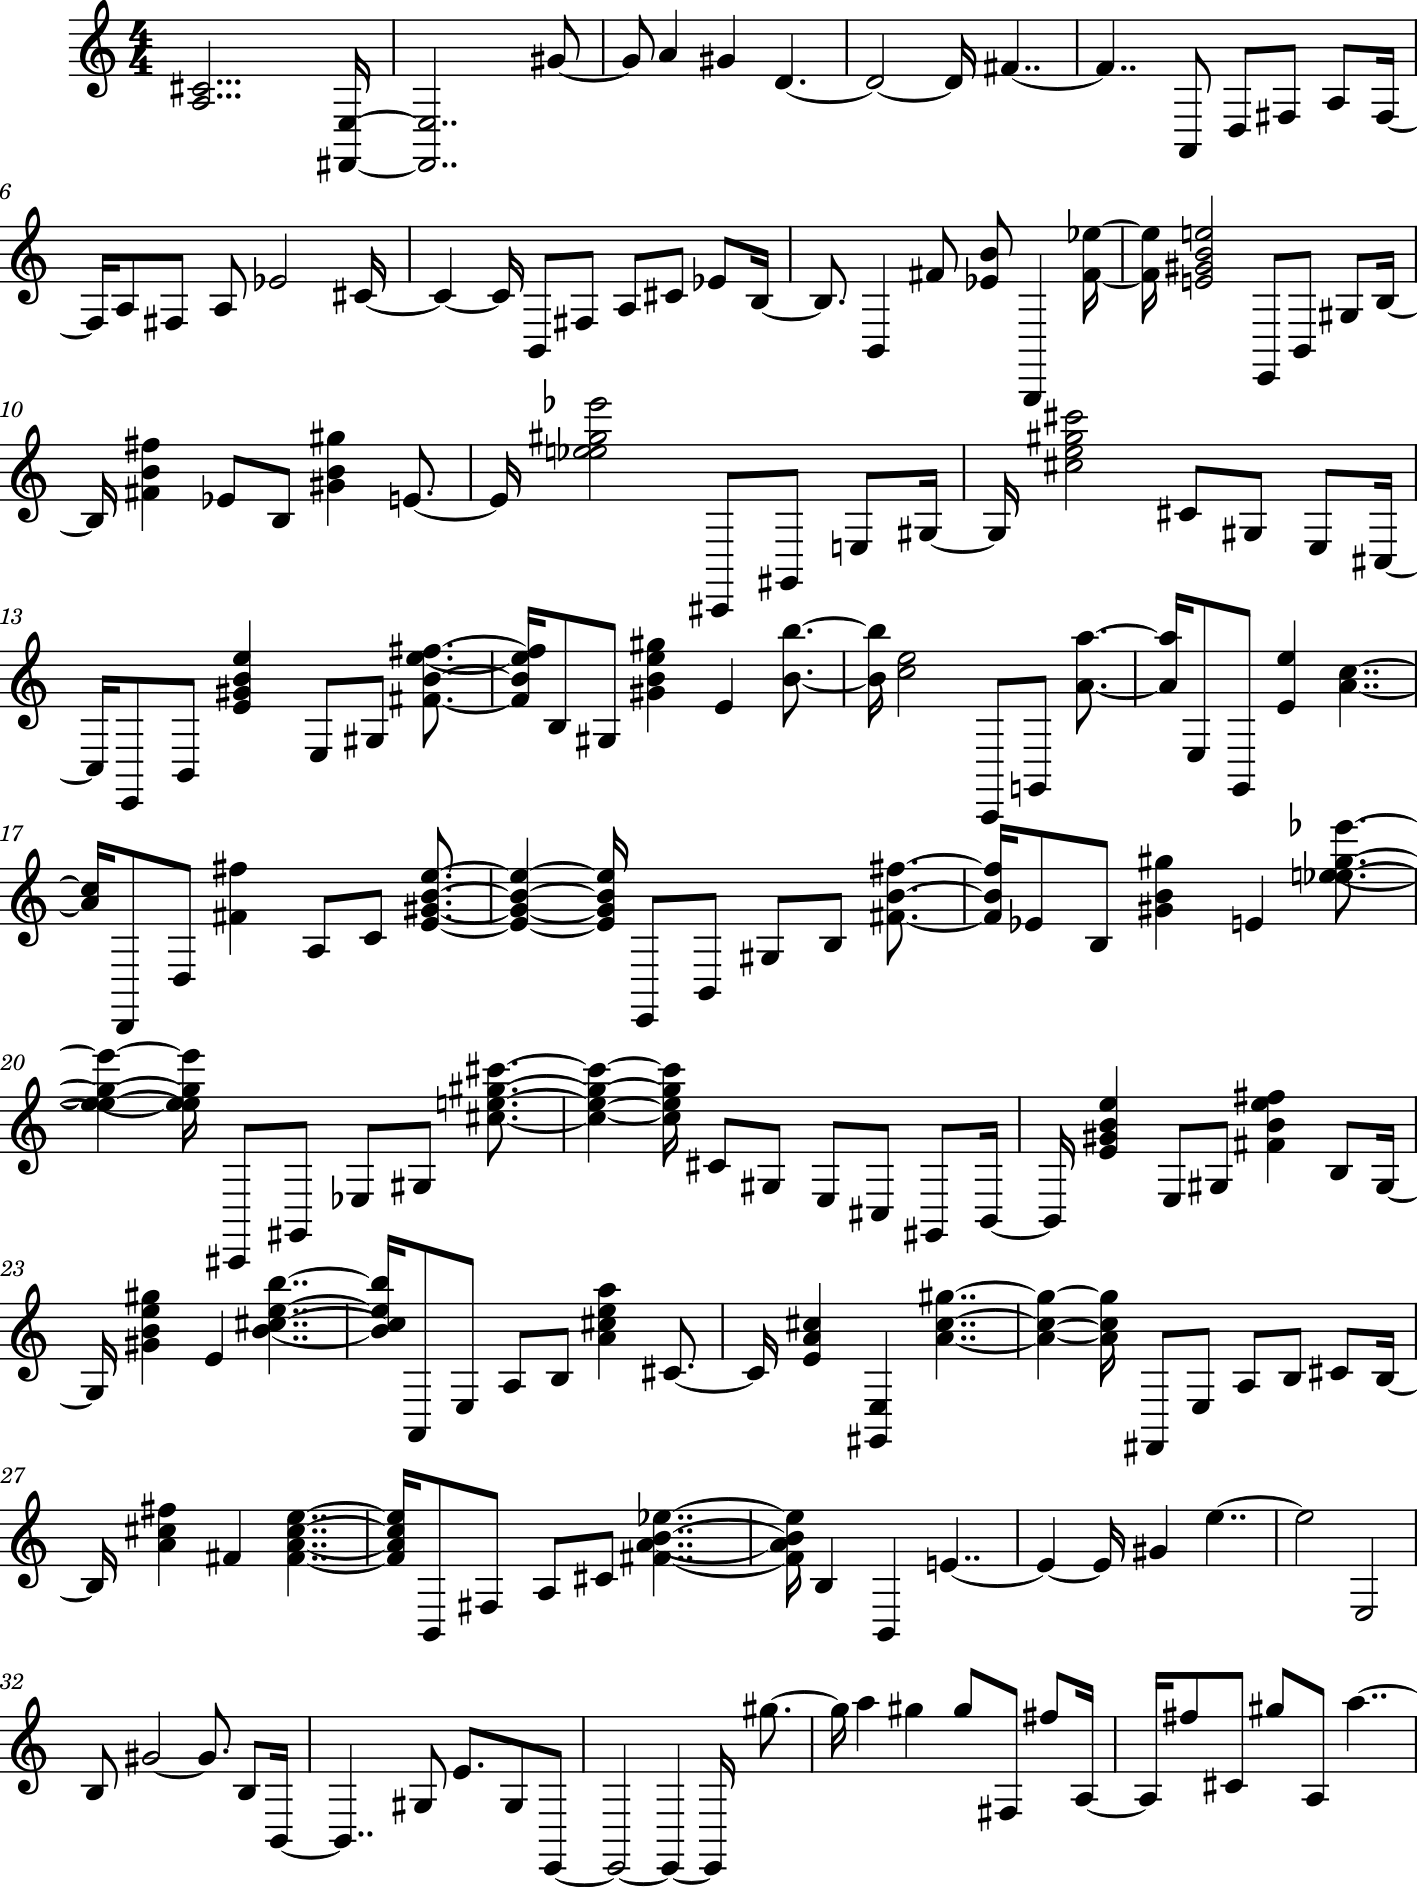

In [48]:
midi_stream.show()

In [50]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [51]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.utils import plot_model
import os

plot_model(model, to_file=os.path.join('model.png'), show_shapes = True, show_layer_names = True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
